# **Imports & Setup**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import zscore

from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.manifold import TSNE
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import RobustScaler, OneHotEncoder, OrdinalEncoder, StandardScaler

import warnings
warnings.filterwarnings("ignore")

# **Dataset Overview**

**Key Features**

| Feature              | Description                              |
|-----------------------|------------------------------------------|
| TransactionAmount    | Monetary value of each transaction, ranging from small everyday expenses to larger purchases. |
| TransactionDate      | Timestamp of each transaction, capturing date and time. |
| TransactionType      | Categorical field indicating 'Credit' or 'Debit' transactions.            |
| Location      | Geographic location of the transaction, represented by U.S. city names.           |
| AccountBalance| Balance in the account post-transaction, with logical correlations based on transaction type and amount.|
| Channel    | Channel through which the transaction was performed (e.g., Online, ATM, Branch).   |
| CustomerAge      | Age of the account holder, with logical groupings based on occupation. |
| CustomerOccupation      | Occupation of the account holder (e.g., Doctor, Engineer, Student, Retired), reflecting income patterns.            |
| TransactionDuration    |Duration of the transaction in seconds, varying by transaction type.   |
| LoginAttempts      |Number of login attempts before the transaction, with higher values indicating potential anomalies.|

In [2]:
df_raw = pd.read_csv("/kaggle/input/bank-transaction-dataset-for-fraud-detection/bank_transactions_data_2.csv")
df = df_raw.copy()
df.head()

TransactionID AccountID  TransactionAmount      TransactionDate  \
0      TX000001   AC00128              14.09  2023-04-11 16:29:14   
1      TX000002   AC00455             376.24  2023-06-27 16:44:19   
2      TX000003   AC00019             126.29  2023-07-10 18:16:08   
3      TX000004   AC00070             184.50  2023-05-05 16:32:11   
4      TX000005   AC00411              13.45  2023-10-16 17:51:24   

  TransactionType   Location DeviceID      IP Address MerchantID Channel  \
0           Debit  San Diego  D000380  162.198.218.92       M015     ATM   
1           Debit    Houston  D000051     13.149.61.4       M052     ATM   
2           Debit       Mesa  D000235  215.97.143.157       M009  Online   
3           Debit    Raleigh  D000187  200.13.225.150       M002  Online   
4          Credit    Atlanta  D000308    65.164.3.100       M091  Online   

   CustomerAge CustomerOccupation  TransactionDuration  LoginAttempts  \
0           70             Doctor                   81              1   
1           68             Doctor                  141              1   
2           19            Student                   56              1   
3           26            Student                   25              1   
4           26            Student                  198              1   

   AccountBalance PreviousTransactionDate  
0         5112.21     2024-11-04 08:08:08  
1        13758.91     2024-11-04 08:09:35  
2         1122.35     2024-11-04 08:07:04  
3         8569.06     2024-11-04 08:09:06  
4         7429.40     2024-11-04 08:06:39

In [3]:
df.describe()

TransactionAmount  CustomerAge  TransactionDuration  LoginAttempts  \
count        2512.000000  2512.000000          2512.000000    2512.000000   
mean          297.593778    44.673965           119.643312       1.124602   
std           291.946243    17.792198            69.963757       0.602662   
min             0.260000    18.000000            10.000000       1.000000   
25%            81.885000    27.000000            63.000000       1.000000   
50%           211.140000    45.000000           112.500000       1.000000   
75%           414.527500    59.000000           161.000000       1.000000   
max          1919.110000    80.000000           300.000000       5.000000   

       AccountBalance  
count     2512.000000  
mean      5114.302966  
std       3900.942499  
min        101.250000  
25%       1504.370000  
50%       4735.510000  
75%       7678.820000  
max      14977.990000

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2512 entries, 0 to 2511
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   TransactionID            2512 non-null   object 
 1   AccountID                2512 non-null   object 
 2   TransactionAmount        2512 non-null   float64
 3   TransactionDate          2512 non-null   object 
 4   TransactionType          2512 non-null   object 
 5   Location                 2512 non-null   object 
 6   DeviceID                 2512 non-null   object 
 7   IP Address               2512 non-null   object 
 8   MerchantID               2512 non-null   object 
 9   Channel                  2512 non-null   object 
 10  CustomerAge              2512 non-null   int64  
 11  CustomerOccupation       2512 non-null   object 
 12  TransactionDuration      2512 non-null   int64  
 13  LoginAttempts            2512 non-null   int64  
 14  AccountBalance          

# **Exploratory Data Analysis (EDA)**

## **Temporal Trends and Anomalies**

In [5]:
df["TransactionDate"] = pd.to_datetime(df["TransactionDate"])
df["PreviousTransactionDate"] = pd.to_datetime(df["PreviousTransactionDate"])

df = df.set_index("TransactionDate").sort_index()

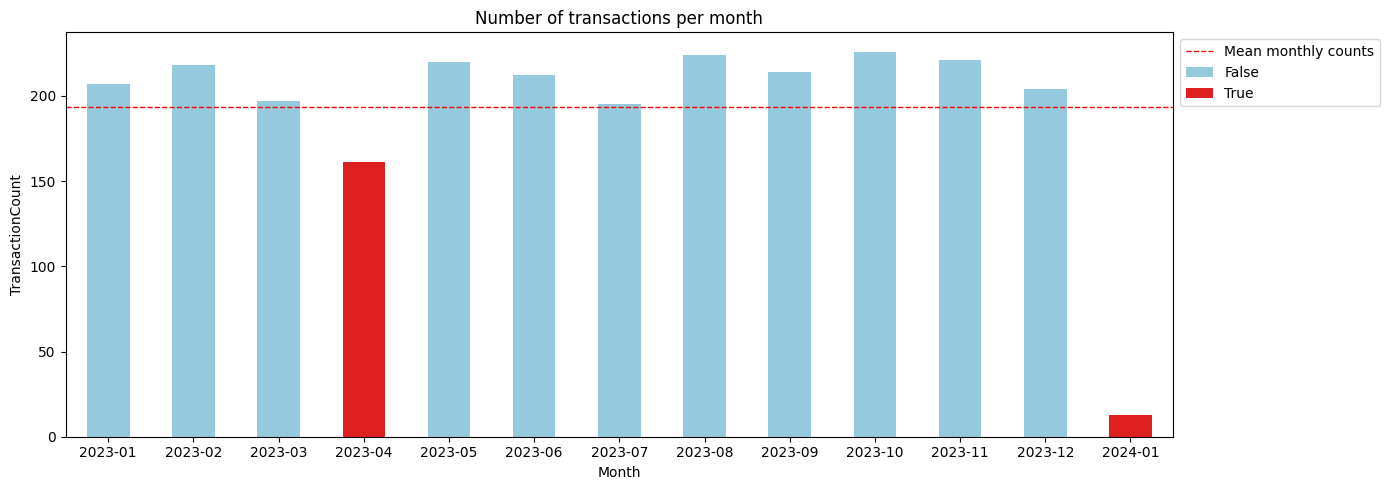

In [6]:
monthly_counts = df.resample("M")["TransactionID"].count().reset_index()
monthly_counts.rename(columns={"TransactionID": "TransactionCount"}, inplace=True)

monthly_counts["Month"] = monthly_counts["TransactionDate"].dt.to_period("M").astype(str)

mean_val = monthly_counts["TransactionCount"].mean()
monthly_counts["BelowMean"] = monthly_counts["TransactionCount"] < mean_val

plt.figure(figsize=(14, 5))
sns.barplot(
    data=monthly_counts, 
    x="Month", 
    y="TransactionCount", 
    hue="BelowMean", 
    dodge=False, 
    width=0.5, 
    palette={False: "skyblue", True: "red"}
)
plt.axhline(y=mean_val, color="red", linestyle="--", linewidth=1, label="Mean monthly counts")
plt.title("Number of transactions per month")
plt.legend(bbox_to_anchor=(1, 1), loc="upper left")
plt.tight_layout()
plt.show()

The plot shows the number of transactions for each month. The dashed line indicates the average monthly value. April 2023 and January 2024 are below this average, which may indicate anomalies.

In [7]:
df["year_month"] = df.index.to_period("M")

days_per_month = df.groupby("year_month").apply(lambda x: x.index.normalize().nunique())

days_per_month_df = pd.DataFrame(days_per_month, columns=["active_days"])
days_per_month_df

active_days
year_month             
2023-01              22
2023-02              20
2023-03              23
2023-04              20
2023-05              23
2023-06              22
2023-07              21
2023-08              23
2023-09              21
2023-10              22
2023-11              22
2023-12              21
2024-01               1

From the table, April 2023 has an average number of active days similar to other months that were above the average (as seen in the previous plot). January 2024 has only 1 active day, which is why it is far below the average.

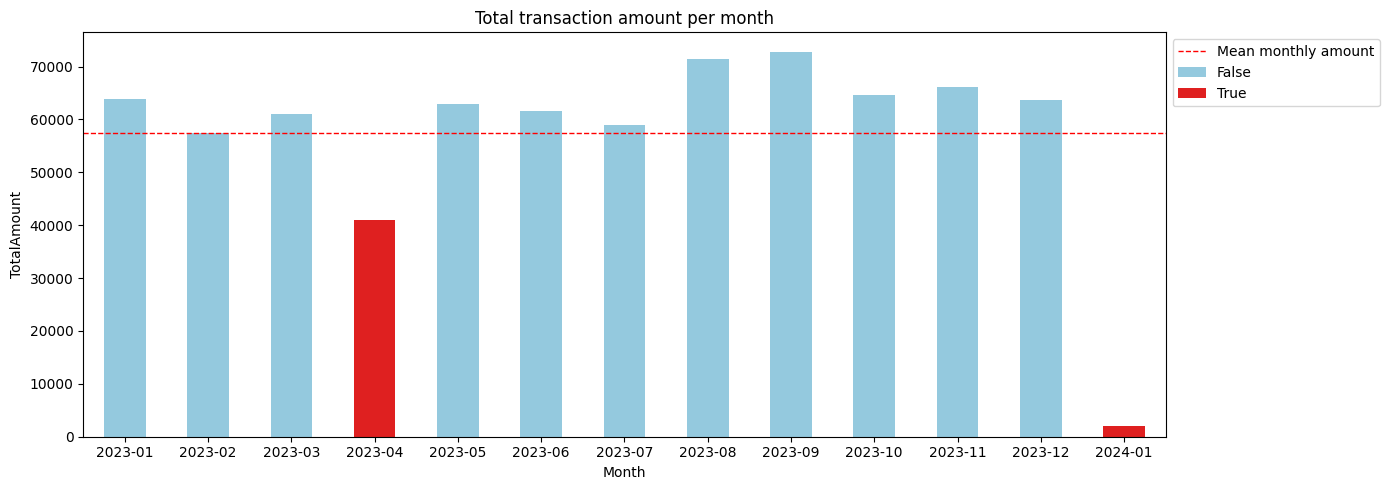

In [8]:
monthly_total = df.resample("M")["TransactionAmount"].sum().reset_index()
monthly_total.rename(columns={"TransactionAmount": "TotalAmount"}, inplace=True)

monthly_total["Month"] = monthly_total["TransactionDate"].dt.to_period("M").astype(str)

mean_total = round(monthly_total["TotalAmount"].mean(), 2)
monthly_total["BelowAvg"] = monthly_total["TotalAmount"] < mean_total

plt.figure(figsize=(14, 5))
sns.barplot(
    data=monthly_total, 
    x="Month", 
    y="TotalAmount", 
    width=0.5, 
    hue="BelowAvg", 
    dodge=False, 
    palette={False: "skyblue", True: "red"}
)
plt.axhline(y=mean_total, color="red", linestyle="--", linewidth=1, label="Mean monthly amount")
plt.title("Total transaction amount per month")
plt.legend(bbox_to_anchor=(1, 1), loc="upper left")
plt.tight_layout()
plt.show()

The plot also shows that the total transaction amount is below the average in April 2023 and January 2024. 

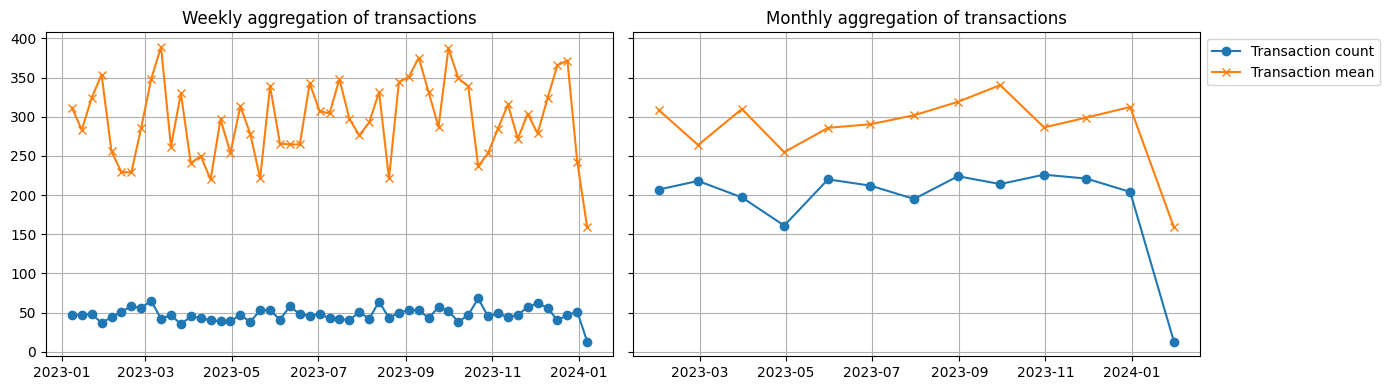

In [9]:
weekly_agg = df.resample("W").agg({
    "TransactionID" : "count",
    "TransactionAmount": "mean"
}).rename(columns={"TransactionID": "TransactionCount", "TransactionAmount": "TransactionMean"})

monthly_agg = df.resample("ME").agg({
    "TransactionID": "count",
    "TransactionAmount": "mean"
}).rename(columns={"TransactionID": "TransactionCount", "TransactionAmount": "TransactionMean"})


plots_data = [
    (weekly_agg, "Weekly aggregation of transactions"),
    (monthly_agg, "Monthly aggregation of transactions")
]

fig, axes = plt.subplots(1, 2, figsize=(14, 4), sharey=True)

for ax, (data, title) in zip(axes, plots_data):
    ax.plot(data.index, data["TransactionCount"], marker="o", label="Transaction count")
    ax.plot(data.index, data["TransactionMean"], marker="x", label="Transaction mean")
    ax.set_title(title)
    ax.grid(True)

plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.tight_layout()
plt.show()


From this aggregation plots, we can identify time periods where transaction counts decrease while the average transaction value increases.

In [10]:
threshold_mean_increase = 10
threshold_count_decrease = -10

wa = weekly_agg.copy()
wa["mean_diff"] = wa["TransactionMean"].diff()
wa["count_diff"] = wa["TransactionCount"].diff()

ma = monthly_agg.copy()
ma["mean_diff"] = ma["TransactionMean"].diff()
ma["count_diff"] = ma["TransactionCount"].diff()

wa_anomalies = wa[
    (wa["mean_diff"] > threshold_mean_increase) &
    (wa["count_diff"] < threshold_count_decrease)
]

ma_anomalies = ma[
    (ma["mean_diff"] > threshold_mean_increase) &
    (ma["count_diff"] < threshold_count_decrease)
]

wa_anomalies, ma_anomalies

(                 TransactionCount  TransactionMean  mean_diff  count_diff
 TransactionDate                                                          
 2023-01-29                     37       353.726216  29.569758       -11.0
 2023-03-12                     42       388.875952  40.927799       -23.0
 2023-03-26                     35       329.970571  68.289720       -12.0
 2023-10-29                     45       253.675778  17.005337       -23.0
 2023-12-17                     40       365.717750  41.980607       -16.0,
                  TransactionCount  TransactionMean  mean_diff  count_diff
 TransactionDate                                                          
 2023-03-31                    197       309.828020  45.992699       -21.0
 2023-07-31                    195       301.853282  11.477905       -17.0
 2023-12-31                    204       312.350147  13.476256       -17.0)

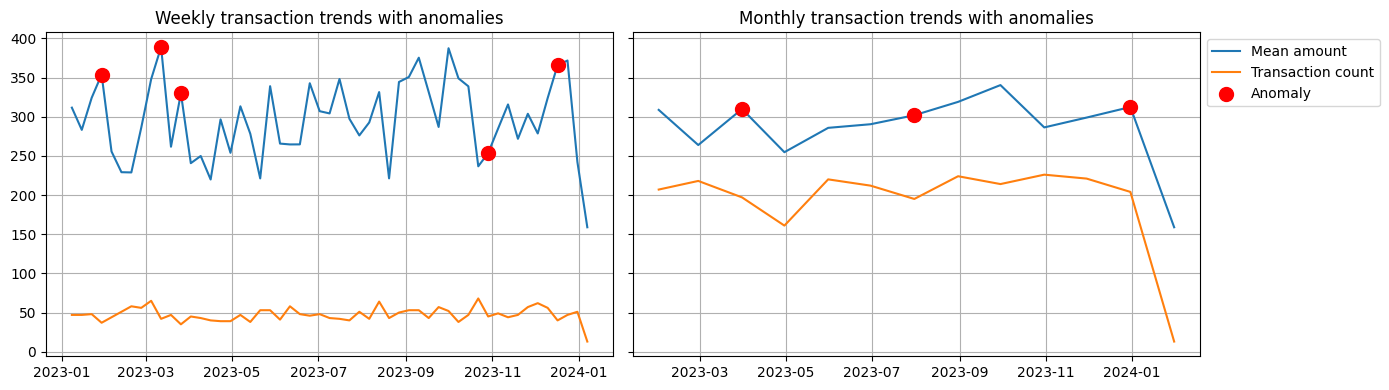

In [11]:
plots_data = [
    (wa, wa_anomalies, "Weekly"),  
    (ma, ma_anomalies, "Monthly")
]

fig, axes = plt.subplots(1, 2, figsize=(14, 4), sharey=True)

for ax, (data, anomaly, title) in zip(axes, plots_data):
    ax.plot(data.index, data["TransactionMean"], label="Mean amount")
    ax.plot(data.index, data["TransactionCount"], label="Transaction count")

    ax.scatter(
        x=anomaly.index, 
        y=anomaly["TransactionMean"], 
        color="red", 
        s=100, 
        zorder=5, 
        label="Anomaly"
    )
    ax.set_title(f"{title} transaction trends with anomalies")
    ax.grid(True)

plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.tight_layout()
plt.show()

On the plots, where the line shows changes in the average transaction amount, points have been added to indicate a large difference between the average transaction value and the number of transactions (weekly and monthly). These points may indicate potential transaction anomalies.

## **Fraud Risk Thresholds**

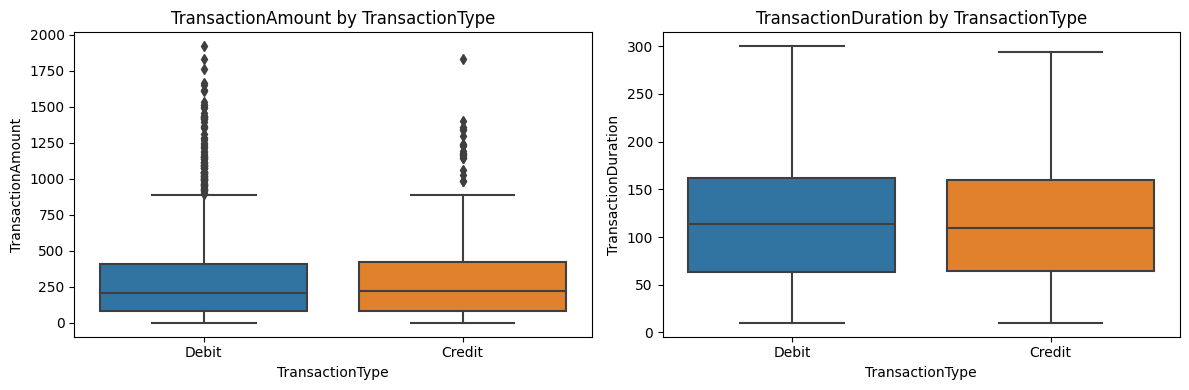

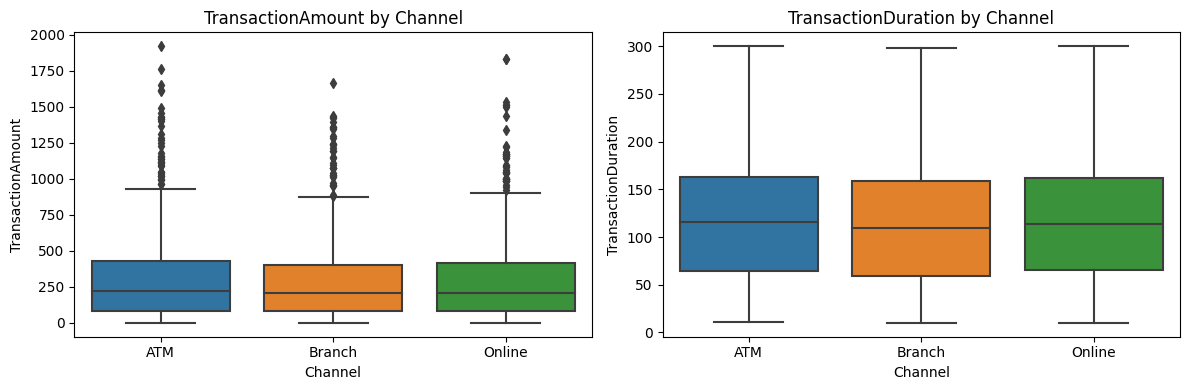

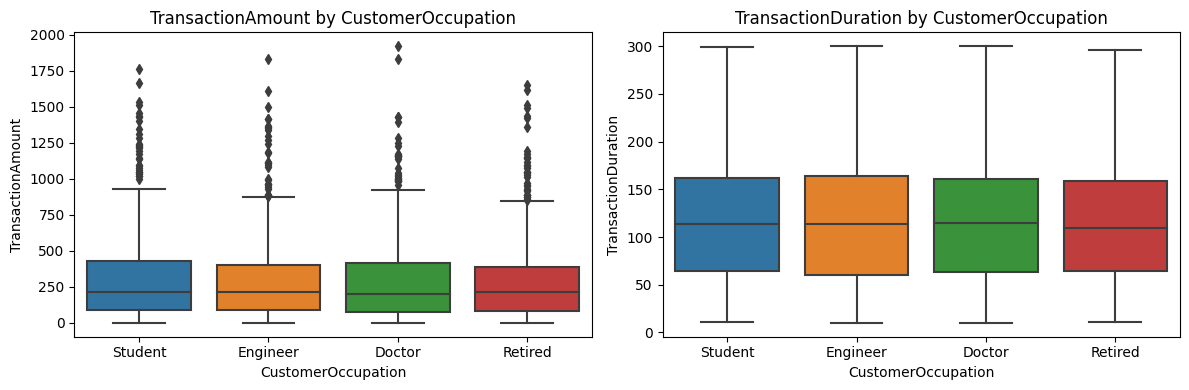

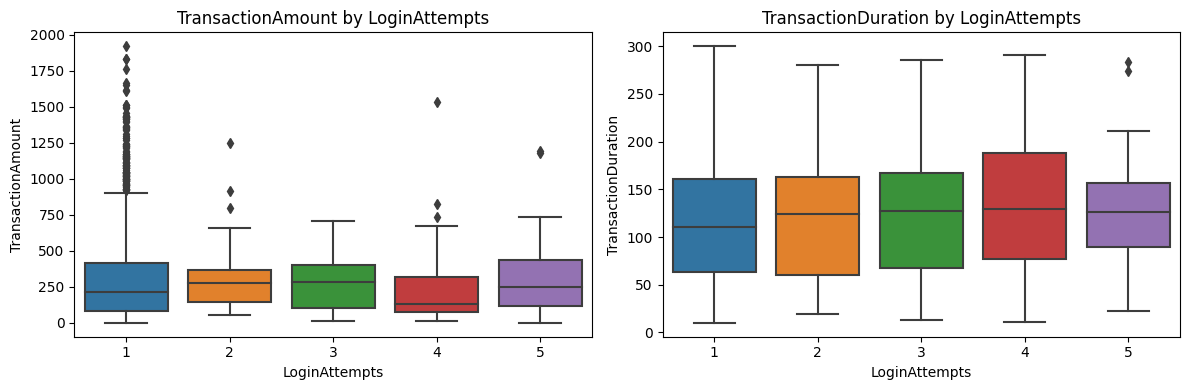

In [12]:
groups = ["TransactionType", "Channel", "CustomerOccupation", "LoginAttempts"]
transaction_cols = ["TransactionAmount", "TransactionDuration"]

for col in groups:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))  

    for ax, transaction in zip(axes, transaction_cols):
        sns.boxplot(
            data=df,
            x=col,
            y=transaction,
            ax=ax,
        )
        ax.set_title(f"{transaction} by {col}")
        ax.set_xlabel(col)
        ax.set_ylabel(transaction)

    plt.tight_layout()
    plt.show()

The boxplots show the distribution of **TransactionAmount** and **TransactionDuration** across different groups. 

For **TransactionDuration**, there are practically no outliers, with only a few appearing for LoginAttempts = 5. 
For **TransactionAmount**, outliers generally start above ~900. In LoginAttempts, most outliers appear when the value is 1, none for 3, and only a few in the other categories.

This shows that high **TransactionAmount** values appear infrequently across all groups, which is why they are flagged as outliers. However, being an outlier does not necessarily mean the transaction is fraudulent.

### **Intuitive Feature Considerations**

When creating boolean features, it’s best to assign a value of 1 to the cases that represent what we’re looking for—in our case, potential fraud.

1. Did the transaction for the account use an IP address different from the one that appeared most frequently in its transactions?
2. Did the transaction for the account occur from a location different from the one that appeared most frequently in its transactions?
3. Did the transaction for the account occur from a device different than the one that appeared most frequently in its transactions?
4. Did the transaction for the account use a MerchantID different from the one that appeared most frequently in its transactions?
5. Does the transaction amount exceed 75% of the balance?
6. Was this transaction made from a new device?
7. Was this transaction made from a new IP address?
8. Was this transaction made from a new location?
9. Was this transaction made for a new MerchantID?

# **Feature Engineering**

### **1. Feature extraction from dates & transformation**

In [13]:
df["Year"] = df.index.year
df["Month"] = df.index.month
df["Day"] = df.index.day
df["Weekday"] = df.index.weekday
df["Hour"] = df.index.hour

# sin/cos transform -> lets the model know that, for example, after December (12) comes January (1)
df["month_sin"] = np.sin(2 * np.pi * df["Month"]/12)
df["month_cos"] = np.cos(2 * np.pi * df["Month"]/12)
df["weekday_sin"] = np.sin(2 * np.pi * df["Weekday"]/7)
df["weekday_cos"] = np.cos(2 * np.pi * df["Weekday"]/7)
df["day_sin"] = np.sin(2 * np.pi * df["Day"]/31)
df["day_cos"] = np.cos(2 * np.pi * df["Day"]/31)

### **2. Feature Without Data Leakage Risk**

In [14]:
df["exceeds_75_percent_balance"] = (
    df["TransactionAmount"] >= 0.75 * (df["TransactionAmount"] + df["AccountBalance"])
).astype(int)

### **3. Feature Creation Based on Analytical Questions**

#### **NOTE:**

#### To create new features based on statistical measures such as mean, standard deviation, or frequency, it is essential to first split the dataset into training and test sets. This step prevents data leakage by ensuring that information from the test set does not influence the training process.

#### Next, because the data is time-ordered, we compute these features using rolling windows—calculating statistics based only on past transactions up to the current one. This preserves the temporal integrity of the data and helps build realistic, leakage-free features for the model.

#### **Data Splitting**

In [15]:
n = len(df)
test_size = int(n * 0.1) # 10% of the dataset

train_df = df.iloc[:-test_size].copy()
test_df = df.iloc[-test_size:].copy()

print(f"Train dataset: {train_df.shape[0]} rows, {train_df.shape[1]} columns.\n"
      f"Test dataset: {test_df.shape[0]} rows, {test_df.shape[1]} columns.")

Train dataset: 2261 rows, 28 columns.
Test dataset: 251 rows, 28 columns.


#### **Utils**

In [16]:
def add_rolling_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Adds rolling mean features for TransactionAmount and TransactionDuration per AccountID.    
    """
    df["rolling_mean_amount"] = df.groupby("AccountID")["TransactionAmount"].transform(
        lambda x: x.shift().rolling(window=2, min_periods=1).mean()
    ).fillna(0)

    df["rolling_mean_duration"] = df.groupby("AccountID")["TransactionDuration"].transform(
        lambda x: x.shift().rolling(window=2, min_periods=1).mean()
    ).fillna(0)
    
    return df


def add_group_based_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Adds per-account most frequent categorical values for IP, Location, Device, and Merchant.
    """
    agg = df.groupby("AccountID").agg(
        most_frequent_ip=(
            "IP Address", lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan
        ),
        most_frequent_location=(
            "Location", lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan
        ),
        most_frequent_device=(
            "DeviceID", lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan
        ),
        most_frequent_merchant=(
            "MerchantID", lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan
        ),
    )
    
    df = df.merge(agg, on="AccountID", how="left").set_index(df.index)
    return df


def add_unusual_usage_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Creates boolean features indicating if current transaction deviates 
    from most frequent account behavior.
    """
    df["is_not_most_frequent_ip"] = (df["IP Address"] != df["most_frequent_ip"]).astype(int)
    df["is_not_most_frequent_location"] = (df["Location"] != df["most_frequent_location"]).astype(int)
    df["is_not_most_frequent_device"] = (df["DeviceID"] != df["most_frequent_device"]).astype(int)
    df["is_not_most_frequent_merchant"] = (df["MerchantID"] != df["most_frequent_merchant"]).astype(int)
    
    return df


def add_time_since_last_transaction(df: pd.DataFrame) -> pd.DataFrame:
    """
    Measures time difference from previous transaction per AccountID.
    """
    df["time_since_last_transaction"] = (df.groupby("AccountID")
        .apply(lambda g: g.index.to_series().diff().dt.total_seconds()) 
        .reset_index(level=0, drop=True)   # level 0 - to delete only grouping level
    ).fillna(0)
    
    return df

#### **Creating**

In [17]:
feature_functions = [
    add_rolling_features,
    add_group_based_features,
    add_unusual_usage_features,
    add_time_since_last_transaction
]

for func in feature_functions:
    train_df = func(train_df)
    test_df = func(test_df)

# **Outlier Detection Approaches**

## **Statistical Outlier Measures**

We will statistically check only the values above the mean (Z-score) and above the 50th percentile (IQR).

### **Z-Score**

It tells us how far a value is from the average (mean) in terms of standard deviations (std). 

In [18]:
rows = []

for col in groups:
    unique_vals = df[col].dropna().unique()
    
    for val in unique_vals:
        subset = df[df[col] == val]["TransactionAmount"]
        mean = subset.mean()
        std = subset.std()
        
        moderate_threshold = mean + 2 * std
        extreme_threshold = mean + 3 * std
        
        rows.append({
            "feature": col,
            "value": val,
            "moderate_threshold": moderate_threshold,
            "extreme_threshold": extreme_threshold
        })

thresholds_zscore_df = pd.DataFrame(rows)
thresholds_zscore_df

feature     value  moderate_threshold  extreme_threshold
0      TransactionType     Debit          880.046280        1172.573792
1      TransactionType    Credit          886.556239        1176.583857
2              Channel       ATM          914.745497        1218.257843
3              Channel    Branch          846.607058        1125.795955
4              Channel    Online          883.621337        1176.824644
5   CustomerOccupation   Student          922.454493        1227.071366
6   CustomerOccupation  Engineer          855.365125        1138.527639
7   CustomerOccupation    Doctor          877.600523        1170.050697
8   CustomerOccupation   Retired          867.071191        1153.339950
9        LoginAttempts         1          883.577661        1176.352964
10       LoginAttempts         4          887.406115        1204.228079
11       LoginAttempts         5          901.807509        1198.230325
12       LoginAttempts         2          907.953416        1194.891235
13       LoginAttempts         3          654.250569         848.413919

### **Interquartile Range (IQR)**

It measures the range of the middle 50% of the data (between 25th and 75th percentile). Values far outside this range are considered outliers.

In [19]:
rows = []

for col in groups:
    unique_vals = df[col].dropna().unique()
    
    for val in unique_vals:
        subset = df[df[col] == val]["TransactionAmount"]
        Q1 = subset.quantile(0.25)
        Q3 = subset.quantile(0.75)
        IQR = Q3 - Q1
        moderate_threshold = Q3 + 1.5 * IQR
        extreme_threshold = Q3 + 3 * IQR
        
        rows.append({
            "feature": col,
            "value": val,
            "moderate_threshold": moderate_threshold,
            "extreme_threshold": extreme_threshold
        })

thresholds_iqr_df = pd.DataFrame(rows)
thresholds_iqr_df

feature     value  moderate_threshold  extreme_threshold
0      TransactionType     Debit           894.75625          1381.7275
1      TransactionType    Credit           943.03125          1460.8425
2              Channel       ATM           941.89000          1456.0900
3              Channel    Branch           880.04125          1358.1475
4              Channel    Online           917.56500          1420.5000
5   CustomerOccupation   Student           939.97500          1450.8000
6   CustomerOccupation  Engineer           877.30000          1350.9700
7   CustomerOccupation    Doctor           920.46000          1426.2150
8   CustomerOccupation   Retired           851.26000          1314.1450
9        LoginAttempts         1           918.84875          1421.4500
10       LoginAttempts         4           679.55375          1041.7400
11       LoginAttempts         5           910.17500          1384.4075
12       LoginAttempts         2           709.96750          1049.5000
13       LoginAttempts         3           852.38250          1301.4450

## **Model-Based Outlier Detection**

### **Features**

In [20]:
cat_features = [
    "TransactionType", "Channel", "CustomerOccupation"
]

num_features = [
    "TransactionAmount", "CustomerAge", "TransactionDuration",
    "LoginAttempts", "AccountBalance", "Year", "Hour", "month_sin", 
    "month_cos", "weekday_sin", "weekday_cos", "day_sin", "day_cos", 
    "time_since_last_transaction"
]

not_usefull_features = [
    "TransactionID", "AccountID", "DeviceID", "MerchantID", 
    "IP Address", "Location", "PreviousTransactionDate", "year_month",
    "Month", "Day", "Weekday", "most_frequent_ip", "most_frequent_location",
    "most_frequent_device", "most_frequent_merchant"
]


train_df.drop(columns=not_usefull_features, inplace=True)
test_df.drop(columns=not_usefull_features, inplace=True)

### **Isolation Forest**

In [21]:
train_if = train_df.copy()
test_if = test_df.copy()

# Ordinal Encoder
orde = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
train_if[cat_features] = orde.fit_transform(train_if[cat_features])
test_if[cat_features] = orde.transform(test_if[cat_features])

# Prediction
iso_forest = IsolationForest(contamination=0.05, random_state=42)
train_labels = iso_forest.fit_predict(train_if)
train_if["isFraud"] = (train_labels == -1).astype(int)

test_labels = iso_forest.predict(test_if)
test_if["isFraud"] = (test_labels == -1).astype(int)

### **Local Outlier Factor**

In [22]:
train_lof = train_df.copy()
test_lof = test_df.copy()

# One-Hot Encoder
ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

# Train Dataset
cat_encoded_train = ohe.fit_transform(train_lof[cat_features])
cat_encoded_train_df = pd.DataFrame(cat_encoded_train, 
                              columns=ohe.get_feature_names_out(cat_features), 
                              index=train_lof.index)
train_lof_dropped = train_lof.drop(columns=cat_features)
train_lof_encoded = pd.concat([train_lof_dropped, cat_encoded_train_df], axis=1)

# Test Dataset
cat_encoded_test = ohe.transform(test_lof[cat_features])
cat_encoded_test_df = pd.DataFrame(cat_encoded_test,
                                  columns=ohe.get_feature_names_out(cat_features),
                                  index=test_lof.index)
test_lof_dropped = test_lof.drop(columns=cat_features) 
test_lof_encoded = pd.concat([test_lof_dropped, cat_encoded_test_df], axis=1)

# Robust Scaler
rbs = RobustScaler()
# Train Dataset
train_lof_encoded[num_features] = rbs.fit_transform(train_lof_encoded[num_features])
# Test Dataset
test_lof_encoded[num_features] = rbs.transform(test_lof_encoded[num_features])

# Prediction
lof = LocalOutlierFactor(contamination=0.05, novelty=True)  
lof.fit(train_lof_encoded)
train_labels = lof.predict(train_lof_encoded)
test_labels = lof.predict(test_lof_encoded)

train_lof_encoded["isFraud"] = (train_labels == -1).astype(int)
test_lof_encoded["isFraud"] = (test_labels == -1).astype(int)

## **2D Feature Pair Analysis** 

#### **Pairs**

1. TransactionAmount & TransactionDuration ➡︎ An expensive and very fast transaction.
2. TransactionAmount & AccountBalance ➡︎ An unusually large transaction relative to the account balance.
3. LoginAttempts & TransactionAmount ➡︎ Multiple login attempts followed by a large transaction.
4. TransactionAmount & TimeSinceLastTransaction ➡︎ A very large transaction after a long period of inactivity.
5. TransactionDuration	& LoginAttempts ➡︎ A long transaction combined with multiple logins.


In [23]:
pairs = [
    ("TransactionAmount", "TransactionDuration"),
    ("TransactionAmount", "AccountBalance"),
    ("LoginAttempts", "TransactionAmount"),
    ("TransactionAmount", "time_since_last_transaction"),
    ("TransactionDuration", "LoginAttempts")
]

### **Learning on 2 features (2D feature pairs)**

For this analysis, the anomaly detection models were trained only on two selected variables, which were then compared directly on the visualizations. This approach allows for a clear two-dimensional interpretation of how each algorithm identifies anomalies.

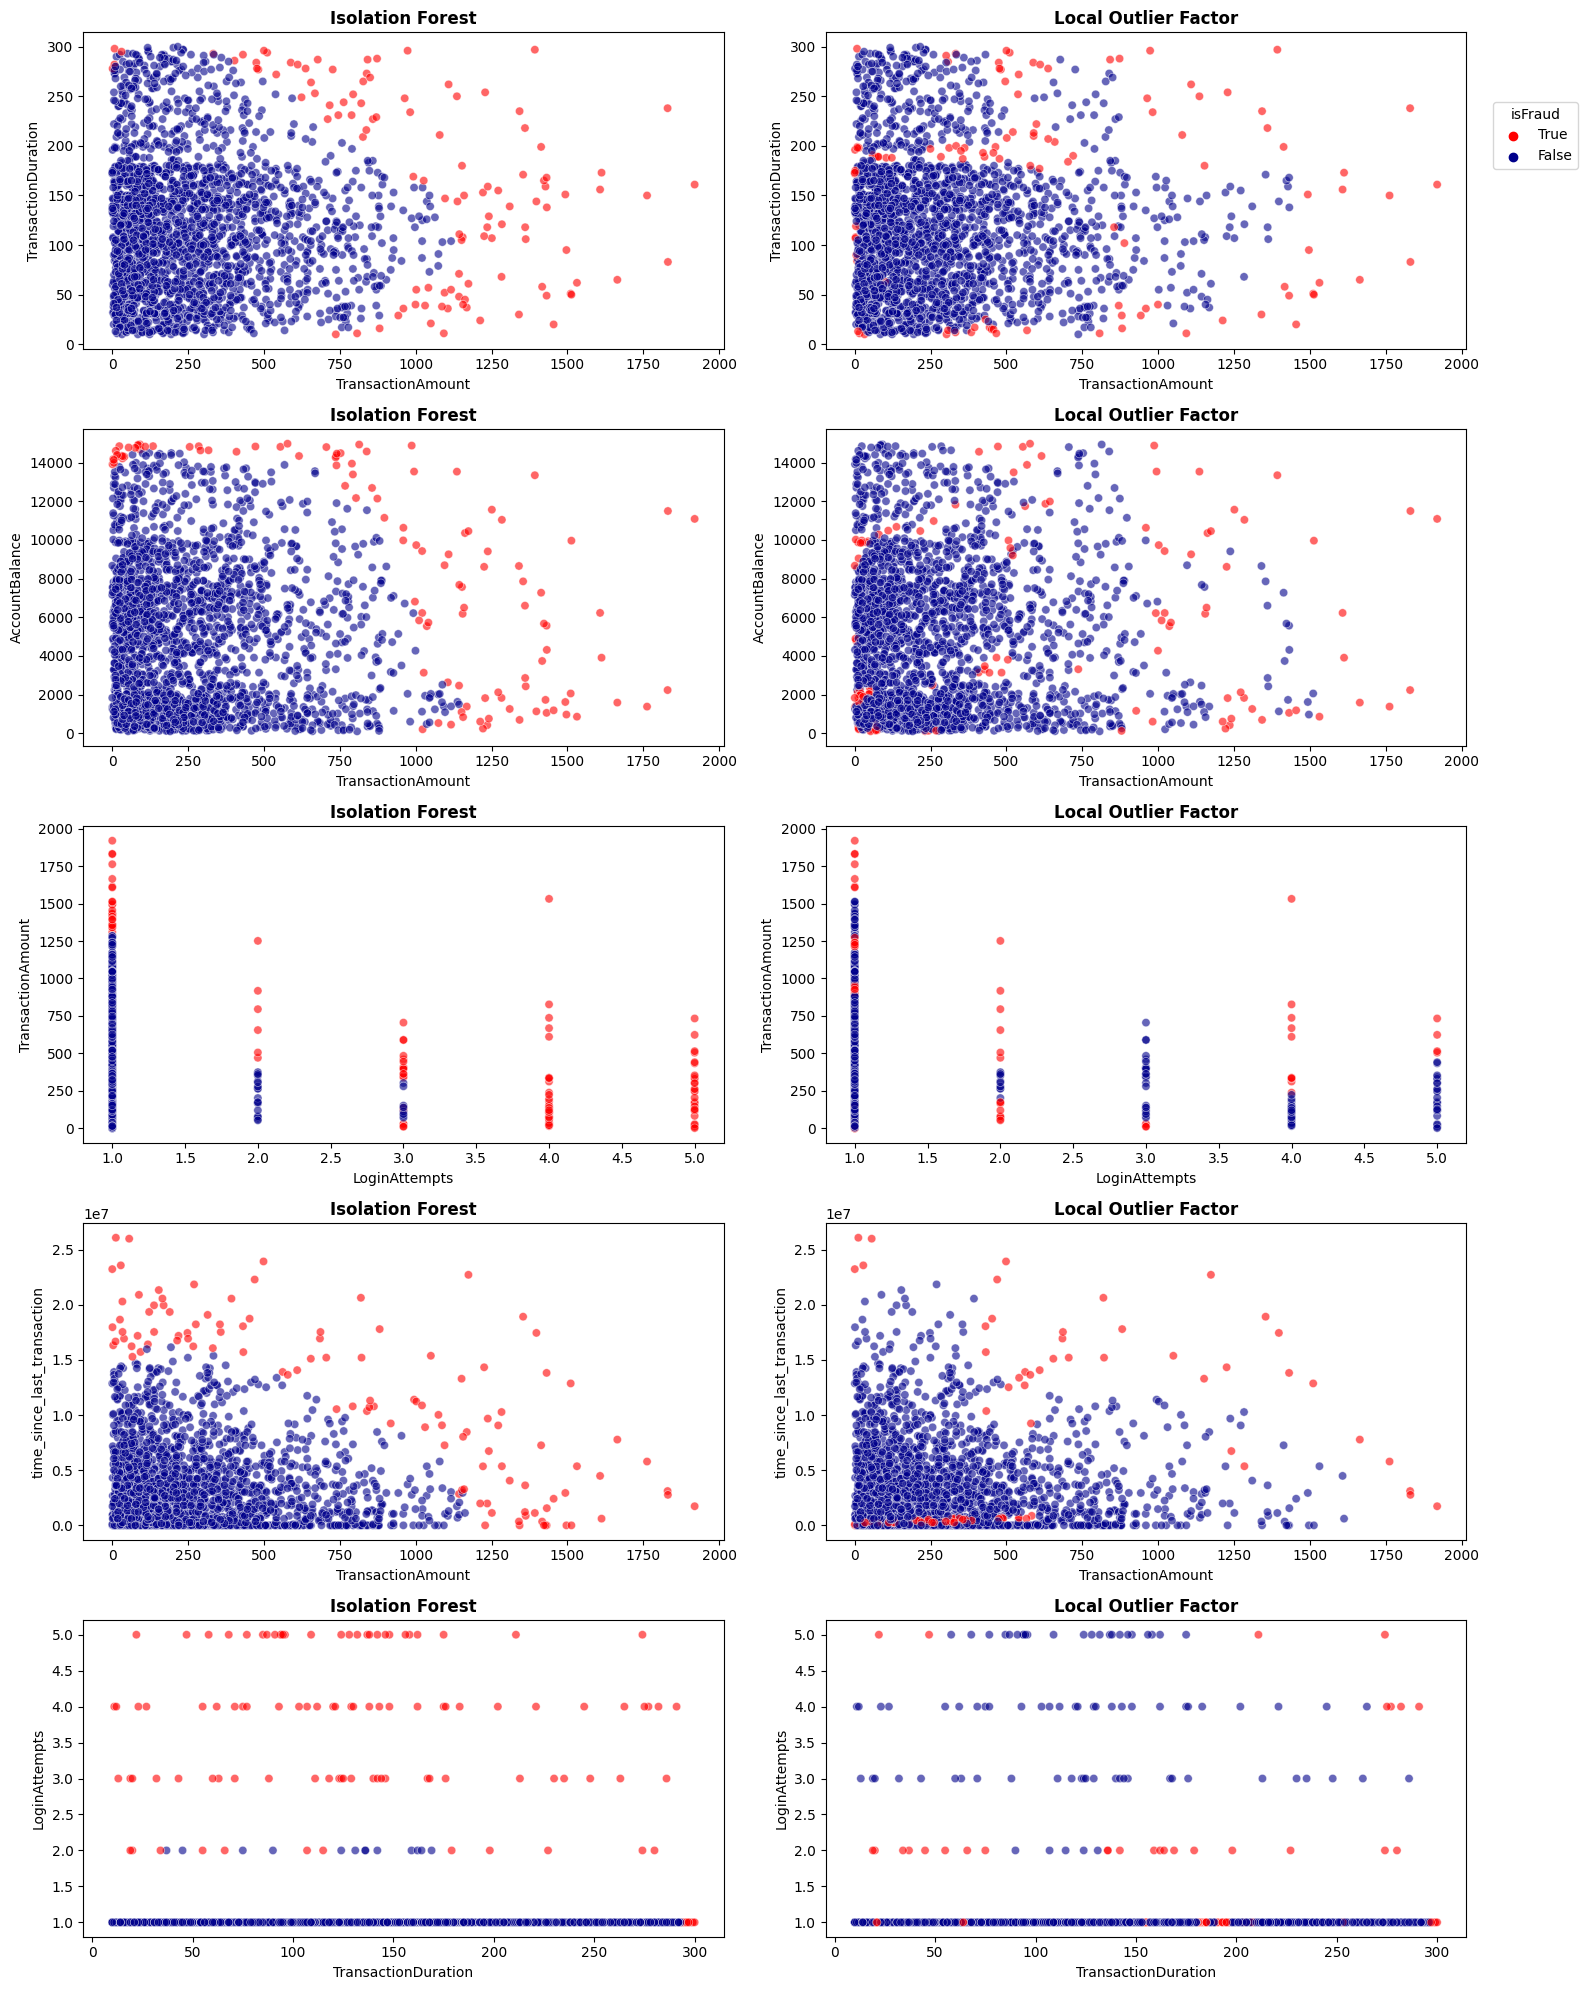

In [24]:
fig, axes = plt.subplots(len(pairs), 2, figsize=(15, 4*len(pairs)))

for i, (x, y) in enumerate(pairs):
    X = train_df[[x, y]].dropna()

    # Isolation Forest
    iso = IsolationForest(contamination=0.05, random_state=42)
    iso_labels = iso.fit_predict(X)
    X_iso = X.copy()
    X_iso["isFraud"] = iso_labels
    
    sns.scatterplot(
        data=X_iso, x=x, y=y, hue="isFraud",
        palette={1: "darkblue", -1: "red"}, ax=axes[i, 0], alpha=0.6
    )
    axes[i, 0].set_title("Isolation Forest", fontsize=12, fontweight="bold")
    axes[i, 0].legend([], [], frameon=False)
    
    # Local Outlier Factor
    X_lof = X.copy()
    X_lof_scaled = RobustScaler().fit_transform(X_lof)
    lof = LocalOutlierFactor(contamination=0.05)
    lof_labels = lof.fit_predict(X_lof_scaled)
    X_lof["isFraud"] = lof_labels
    
    sns.scatterplot(
        data=X_lof, x=x, y=y, hue="isFraud",
        palette={1: "darkblue", -1: "red"}, ax=axes[i, 1], alpha=0.6
    )
    axes[i, 1].set_title("Local Outlier Factor", fontsize=12, fontweight="bold")
    axes[i, 1].legend([], [], frameon=False)
    

handles, labels = axes[0, 0].get_legend_handles_labels()

label_map = {"1": "False", "-1": "True"}
labels = [label_map.get(l, l) for l in labels]

fig.legend(
    handles=handles,
    labels=labels,
    loc="upper right",
    bbox_to_anchor=(1.06, 0.95),
    title="isFraud",
)

plt.tight_layout()
plt.show()

**Isolation Forest** - this method intuitively detects outliers, primarily those with very large values of the analyzed variables (example: high transaction amounts or many login attempts). The further a point lies from the main cluster of data, the more likely it is to be flagged as fraudulent.

**Local Outlier Factor** - in contrast, focuses on the density of a point’s local neighborhood. It not only captures extreme values but also identifies observations that, although closer to the center of the distribution, differ from their immediate surroundings. This allows it to detect less obvious, structurally "different" anomalies.

<br>

**Summary**

**Isolation Forest** primarily identifies global anomalies – points clearly distant from the bulk of the data.
<br>**Local Outlier Factor** complements this by detecting local anomalies - unusual points within otherwise dense clusters.

### **Learning on full dataset**

In this approach, both models – Isolation Forest and Local Outlier Factor – were trained on the entire dataset, and then visualized on two-dimensional plots of selected variable pairs.

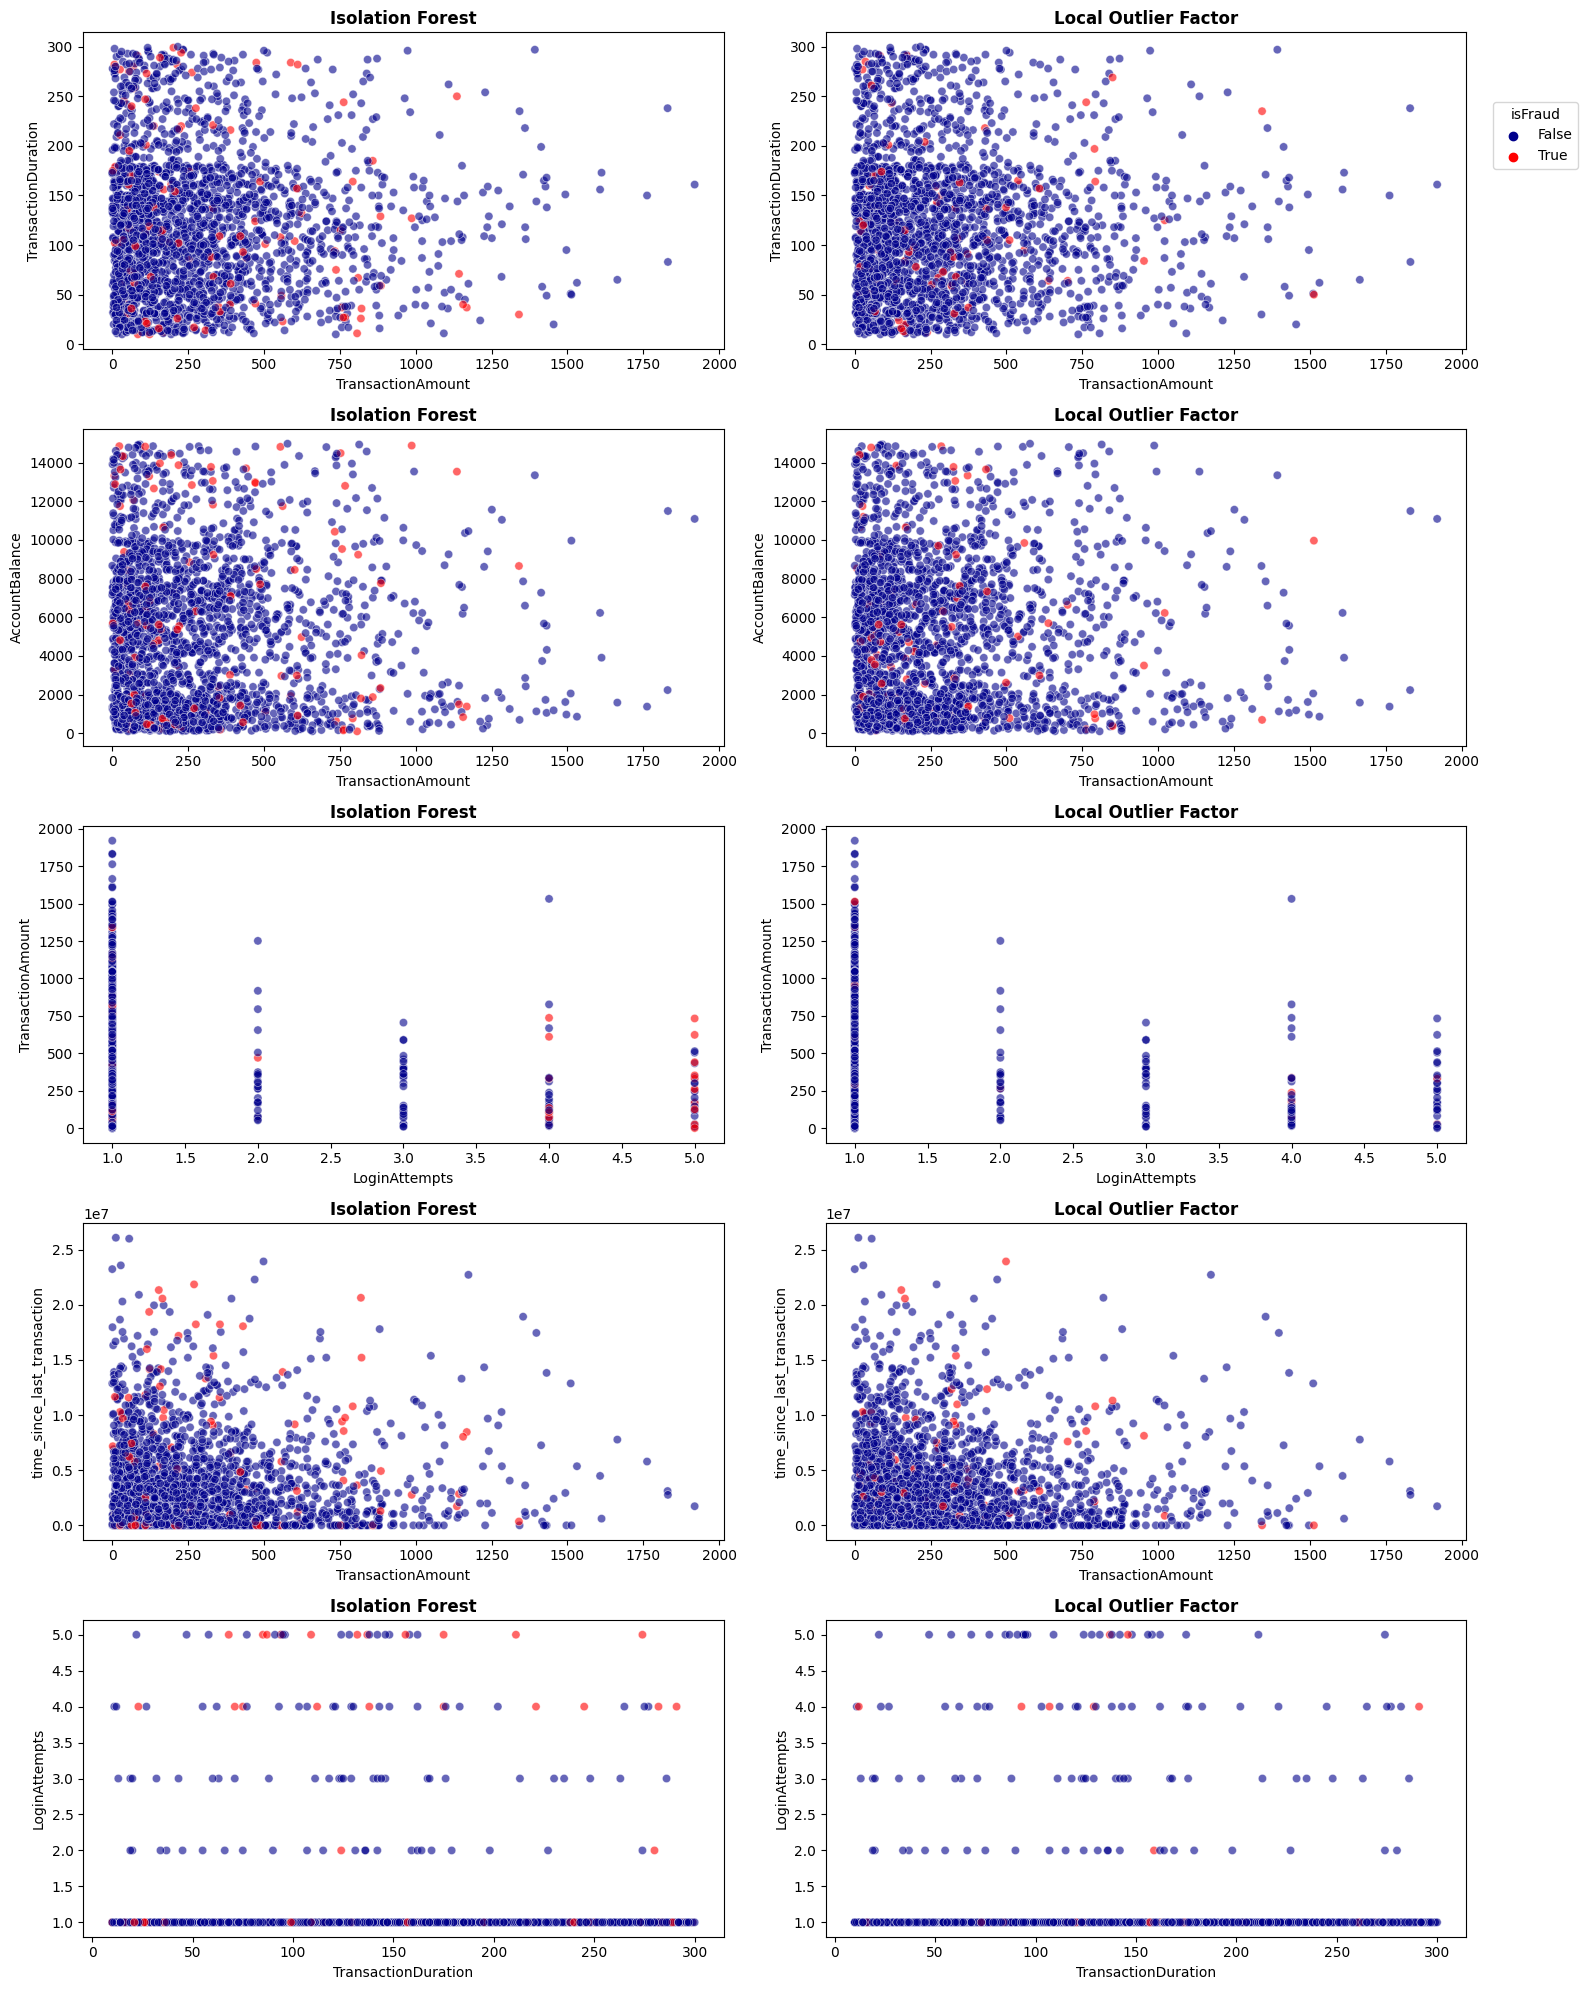

In [25]:
# reverse-scaling
train_lof_tmp = train_lof_encoded.copy()
train_lof_tmp[num_features] = rbs.inverse_transform(train_lof_tmp[num_features])

fig, axes = plt.subplots(len(pairs), 2, figsize=(15, 4*len(pairs)))

for i, (x, y) in enumerate(pairs):
    sns.scatterplot(
        data=train_if, x=x, y=y, hue="isFraud",
        palette={0: "darkblue", 1: "red"}, ax=axes[i, 0], alpha=0.6
    )
    axes[i, 0].set_title("Isolation Forest", fontsize=12, fontweight="bold")
    axes[i, 0].legend([], [], frameon=False)

    sns.scatterplot(
        data=train_lof_tmp, x=x, y=y, hue="isFraud",
        palette={0: "darkblue", 1: "red"}, ax=axes[i, 1], alpha=0.6
    )
    axes[i, 1].set_title("Local Outlier Factor", fontsize=12, fontweight="bold")
    axes[i, 1].legend([], [], frameon=False)

handles, labels = axes[0, 0].get_legend_handles_labels()

label_map = {"0": "False", "1": "True"}
labels = [label_map.get(l, l) for l in labels]

fig.legend(
    handles=handles,
    labels=labels,
    loc="upper right",
    bbox_to_anchor=(1.06, 0.95),
    title="isFraud",
)

plt.tight_layout()
plt.show()

**General observations**
<br>This time, the results of both algorithms are quite similar – they identify largely the same observations as potential frauds. However, the flagged points are scattered across the plots and do not always correspond to the intuitive idea. This suggests that the models capture more complex patterns in the data.

**Differences**
<br>The main difference appears in the variable LoginAttempt. Here, Isolation Forest tends to flag more anomalies for transactions with a high number of login attempts.

<br>

**Summary**

- Both models detect mostly the same anomalies.
- The anomalies are spread across the feature space, making them less intuitive to interpret visually.
- Isolation Forest puts stronger emphasis on unusually high numbers of login attempts compared to LOF.

# **Model Comparison**

In [26]:
df_if_full = pd.concat([train_if, test_if]).sort_index()
df_lof_full = pd.concat([train_lof_encoded, test_lof_encoded]).sort_index()

# reverse-scalling for lof dataset
df_lof_full[num_features] = rbs.inverse_transform(df_lof_full[num_features])

In [27]:
df_if_full["year_month"] = df_if_full.index.to_period("M")
df_lof_full["year_month"] = df_lof_full.index.to_period("M")

if_perc  = df_if_full.groupby("year_month")["isFraud"].mean() * 100
lof_perc = df_lof_full.groupby("year_month")["isFraud"].mean() * 100

models_monthly_pct = round(pd.DataFrame(
    [if_perc, lof_perc], index=["IF: Fraud/Month [%]", "LOF: Fraud/Month [%]"]
), 2)
models_monthly_pct 

year_month            2023-01  2023-02  2023-03  2023-04  2023-05  2023-06  \
IF: Fraud/Month [%]      3.86     3.21     5.08     6.83     3.64     6.13   
LOF: Fraud/Month [%]     1.45     5.50     5.58     4.35     5.45     4.25   

year_month            2023-07  2023-08  2023-09  2023-10  2023-11  2023-12  \
IF: Fraud/Month [%]      2.56     4.02     7.48     7.52    14.03    42.65   
LOF: Fraud/Month [%]     3.59     2.23     3.27     3.98     2.71     5.88   

year_month            2024-01  
IF: Fraud/Month [%]     38.46  
LOF: Fraud/Month [%]     7.69

In [28]:
data = {
    "IF": df_if_full,
    "LOF": df_lof_full
}

summaries = []

for model, dataset in data.items():
    fraud_stats = dataset[dataset["isFraud"] == 1].copy()
    
    summaries.append({
        "model": model,
        "avg_fraud_per_day": fraud_stats.groupby(fraud_stats.index.date).size().mean(),
        "avg_fraud_per_month": fraud_stats.groupby(fraud_stats.index.to_period("M")).size().mean(),
        "max_fraud_amount": fraud_stats["TransactionAmount"].max(),
        "min_fraud_amount": fraud_stats["TransactionAmount"].min(),
        "max_fraud_duration": fraud_stats["TransactionDuration"].max(),
        "min_fraud_duration": fraud_stats["TransactionDuration"].min(),
        "sum_fraud": fraud_stats["isFraud"].sum()
    })
    
summary_table = pd.DataFrame(summaries).set_index("model")
summary_table

avg_fraud_per_day  avg_fraud_per_month  max_fraud_amount  \
model                                                             
IF              1.940171            17.461538           1431.54   
LOF             1.311688             7.769231           1512.99   

       min_fraud_amount  max_fraud_duration  min_fraud_duration  sum_fraud  
model                                                                       
IF                 1.93               300.0                10.0        227  
LOF                6.30               291.0                12.0        101

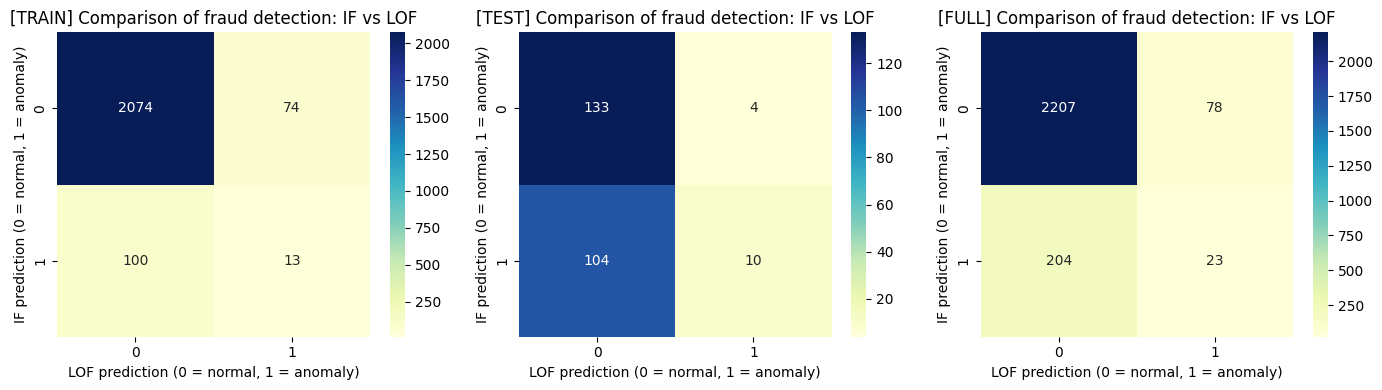

In [29]:
cts = [
    pd.crosstab(train_if["isFraud"], train_lof_encoded["isFraud"]),
    pd.crosstab(test_if["isFraud"], test_lof_encoded["isFraud"]),
    pd.crosstab(df_if_full["isFraud"], df_lof_full["isFraud"])
]
titles = ["[TRAIN]", "[TEST]", "[FULL]"]
xlabel = "LOF prediction (0 = normal, 1 = anomaly)"
ylabel = "IF prediction (0 = normal, 1 = anomaly)"


fig, ax = plt.subplots(1, 3, figsize=(14, 4))

for i, (ct, title) in enumerate(zip(cts, titles)):
    sns.heatmap(ct, annot=True, fmt="d", cmap="YlGnBu", ax=ax[i]) 
    ax[i].set_xlabel(xlabel)
    ax[i].set_ylabel(ylabel)
    ax[i].set_title(f"{title} Comparison of fraud detection: IF vs LOF")

plt.tight_layout()
plt.show()

The plots show how the train, test, and full datasets were classified by both models. We can see where both models agreed that a transaction was fraud (IF=1 and LOF=1), where they agreed it was not fraud (IF=0 and LOF=0), and where their predictions were different.

# **High-Confidence Fraud Detection (IF & LOF Agreement)**

### **Definition**

High-Confidence Fraud Detection means focusing on transactions that both algorithms Isolation Forest (global anomaly detection) and Local Outlier Factor (local anomaly detection) agree are suspicious.

Isolation Forest finds points that stand out from the entire dataset, while Local Outlier Factor looks for points that are unusual compared to their closest neighbors.
When both methods flag the same transaction, it’s much more likely to be a true fraud, so we treat these as high-confidence cases.

### **Statistics**

In [30]:
df_full = df_lof_full.copy().drop("isFraud", axis=1)
df_full["common_fraud"] = ((df_if_full["isFraud"] == 1) & (df_lof_full["isFraud"] == 1)).astype(int)

common_fraud_pct = (df_full.groupby("year_month")["common_fraud"].mean() * 100).round(2)

monthly_pct_both = pd.DataFrame([common_fraud_pct.values], columns=common_fraud_pct.index.astype(str), index=["IF+LOF: Fraud/Month [%]"])
monthly_pct_both

year_month               2023-01  2023-02  2023-03  2023-04  2023-05  2023-06  \
IF+LOF: Fraud/Month [%]     0.48      0.0      0.0     0.62     1.36     0.94   

year_month               2023-07  2023-08  2023-09  2023-10  2023-11  2023-12  \
IF+LOF: Fraud/Month [%]     1.03      0.0     0.47     0.44     1.36     4.41   

year_month               2024-01  
IF+LOF: Fraud/Month [%]      0.0

In [31]:
pd.DataFrame({
        "model": ["IF+LOF"],
        "avg_fraud_per_day": [df_full.groupby(df_full.index.date).size().mean()],
        "avg_fraud_per_month": [df_full.groupby(df_full.index.to_period("M")).size().mean()],
        "max_fraud_amount": [df_full["TransactionAmount"].max()],
        "min_fraud_amount": [df_full["TransactionAmount"].min()],
        "max_fraud_duration": [df_full["TransactionDuration"].max()],
        "min_fraud_duration": [df_full["TransactionDuration"].min()],
        "sum_fraud": [df_full["common_fraud"].sum()]
    }).set_index("model")

avg_fraud_per_day  avg_fraud_per_month  max_fraud_amount  \
model                                                              
IF+LOF           9.624521           193.230769           1919.11   

        min_fraud_amount  max_fraud_duration  min_fraud_duration  sum_fraud  
model                                                                        
IF+LOF              0.26               300.0                10.0         23

### **Visualizations**

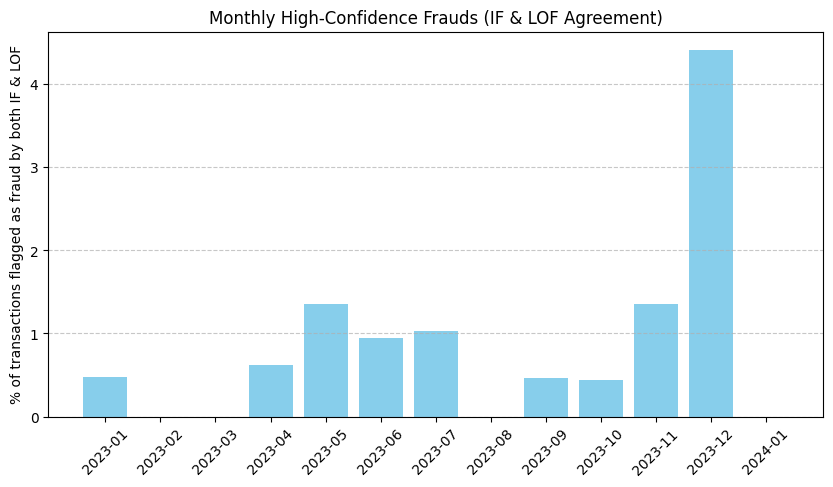

In [32]:
plt.figure(figsize=(10,5))
plt.bar(common_fraud_pct.index.astype(str), common_fraud_pct.values, color="skyblue")
plt.xticks(rotation=45)
plt.ylabel("% of transactions flagged as fraud by both IF & LOF")
plt.title("Monthly High-Confidence Frauds (IF & LOF Agreement)")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

The plot shows that in May 2023, July 2023, and November 2023, more than 1% of transactions were detected as anomalies, with December 2023 exceeding 4%. Intuitively, December stands out because the number of transactions can spike due to the holiday season. Notably, our initial plots ("number of transactions per month" and "total transaction amount per month") highlighted April 2023 and January 2024 as months below average, yet here we can see that the models detect less than 1% anomalies for April and did not identify common anomalies for January.

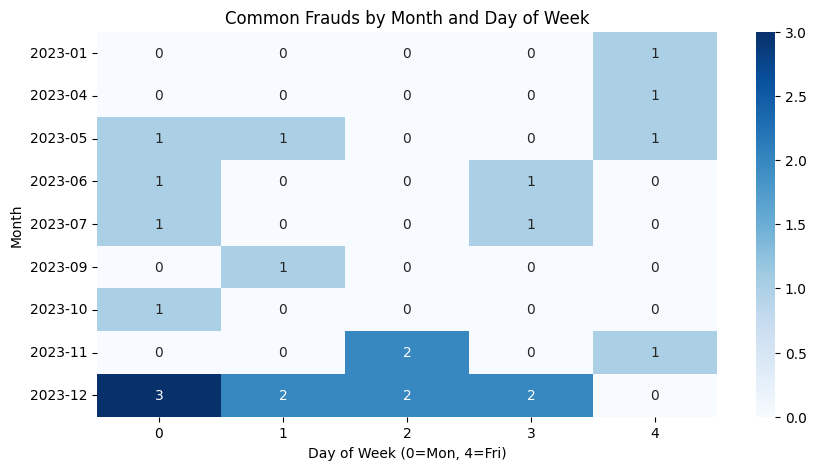

In [33]:
common_fraud = df_full[df_full["common_fraud"] == 1]
common_fraud["weekday"] = common_fraud.index.weekday

plt.figure(figsize=(10, 5))
sns.heatmap(
    pd.crosstab(common_fraud["year_month"], common_fraud["weekday"]),
    cmap="Blues", annot=True, fmt="d"
)
plt.title("Common Frauds by Month and Day of Week")
plt.ylabel("Month")
plt.xlabel("Day of Week (0=Mon, 4=Fri)")
plt.show()

The heatmap shows the number of high-confidence frauds (flagged by both IF and LOF) for each month and day of the week. Darker shades indicate more frauds. We can see which weekdays tend to have more common frauds and how the distribution changes across months.

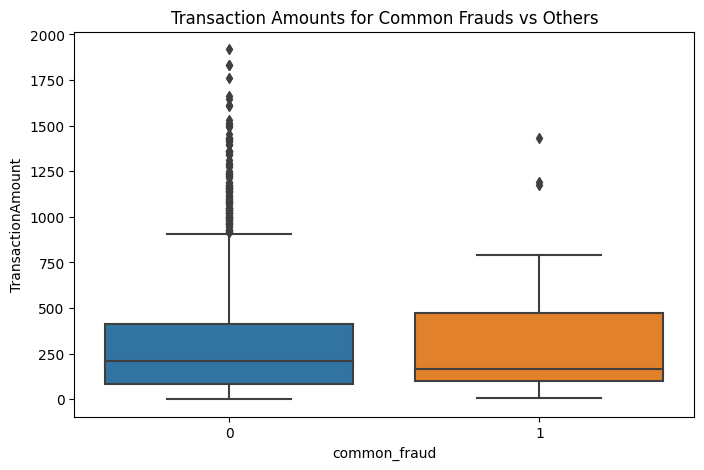

In [34]:
plt.figure(figsize=(8,5))
sns.boxplot(x="common_fraud", y="TransactionAmount", data=df_full)
plt.title("Transaction Amounts for Common Frauds vs Others")
plt.show()


The boxplot compares transaction amounts for those labeled as "common_fraud" (detected as fraud by both IF and LOF models) versus all other transactions. It shows that transactions identified as common fraud generally have higher amounts. For the non-fraud group (common_fraud = 0), there are some outliers starting around 900 — these are unusually high transactions compared to the rest, which is why they were flagged as anomalies, even if they are not actual frauds. Notably, the models classified only a few transactions above 1000 as fraud.

# **Fraud Visualization with PCA & t-SNE**

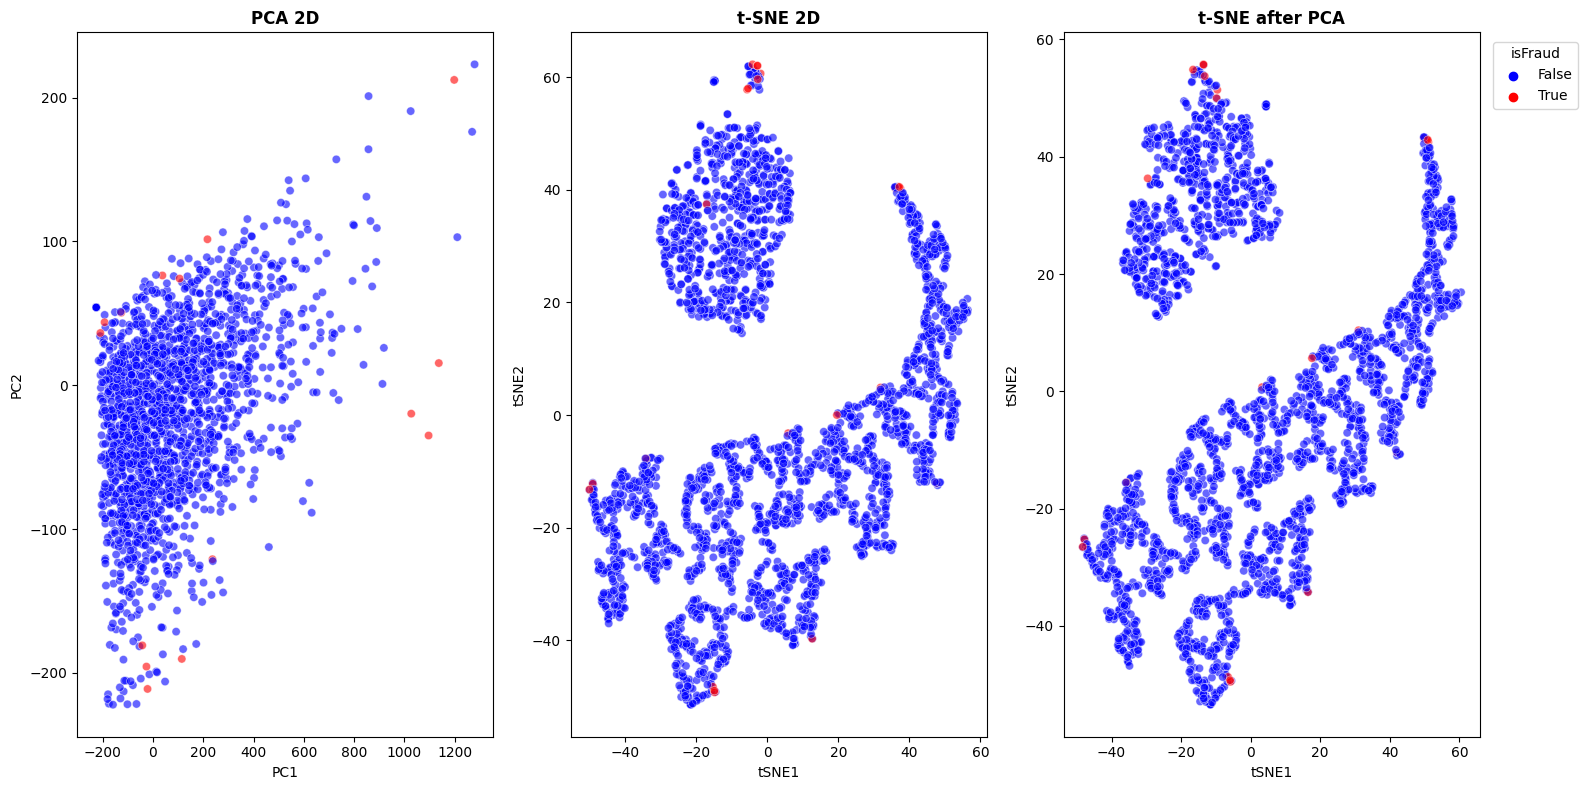

In [35]:
df_vis = df_full.drop(columns=["year_month", "common_fraud"]).copy()

# Standard Scaler
scaler = StandardScaler()
df_vis[num_features] = scaler.fit_transform(df_vis[num_features])

# PCA 2D
pca = PCA(n_components=2)
pca_trans = pca.fit_transform(df_vis)

df_pca_trans = pd.DataFrame(pca_trans, columns=["PC1", "PC2"], index=df_vis.index)
df_pca_trans["isFraud"] = df_full["common_fraud"]

# t-SNE 2D
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
tsne_trans = tsne.fit_transform(df_vis)

df_tsne_trans = pd.DataFrame(tsne_trans, columns=["tSNE1", "tSNE2"], index=df_vis.index)
df_tsne_trans["isFraud"] = df_full["common_fraud"]

# t-SNE after PCA
pca_for_tsne = PCA(n_components=10)
pca_for_tsne_trans = pca_for_tsne.fit_transform(df_vis)

tsne_pca = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
tsne_pca_trans = tsne_pca.fit_transform(pca_for_tsne_trans)

df_tsne_pca_trans = pd.DataFrame(tsne_pca_trans, columns=["tSNE1", "tSNE2"], index=df_vis.index)
df_tsne_pca_trans["isFraud"] = df_full["common_fraud"]

# Visualizations
fig, axes = plt.subplots(1, 3, figsize=(15, 8))

datasets = [
    (df_pca_trans, "PC1", "PC2", "PCA 2D"),
    (df_tsne_trans, "tSNE1", "tSNE2", "t-SNE 2D"),
    (df_tsne_pca_trans, "tSNE1", "tSNE2", "t-SNE after PCA"),
]

for ax, (df, x, y, title) in zip(axes.ravel(), datasets):
    sns.scatterplot(
        data=df, 
        x=x, 
        y=y, 
        hue="isFraud", 
        palette={0: "blue", 1: "red"}, 
        alpha=0.6, 
        ax=ax
    )
    ax.set_title(title, fontsize=12, fontweight="bold")
    ax.legend([], [], frameon=False)

handles, labels = axes[0].get_legend_handles_labels()

label_map = {"0": "False", "1": "True"}
labels = [label_map.get(l, l) for l in labels]

fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.06, 0.95), title="isFraud")

plt.tight_layout()
plt.show()

**PCA 2D ➡︎ t-SNE 2D**

In the PCA 2D plot, the data appears flattened and concentrated in one dense area, since PCA captures only the main linear directions of variation. In contrast, t-SNE 2D separates the data into clearer clusters by preserving local similarities, which makes fraud cases (red points) more visible on the edges of groups.

**PCA:** shows the main axes of variation but can flatten and hide local patterns.<br>
**t-SNE:** shows clusters and anomalies better, because it keeps local similarities even if it loses some of the global scale.

<br>

**tSNE 2D ➡︎ t-SNE after PCA**

The t-SNE projections, both directly and after PCA reduction, look very similar — with clear clusters and fraud cases mostly appearing on the edges. The lack of strong visual differences comes from the fact that the dataset is not extremely high-dimensional or noisy, so t-SNE alone is already effective in capturing the local structure.

# **Conclusion & Next Steps**

In this study, we applied two unsupervised anomaly detection methods — Isolation Forest (IF) and Local Outlier Factor (LOF). The results show that IF is more aggressive in flagging anomalies, while LOF is more conservative, identifying fewer but more certain outliers. By combining the results from both models, we obtained a balanced approach that capturing the most suspicious cases.

**What's next?**

1. **Deep learning models** – leveraging neural networks for more sophisticated anomaly detection.
2. **Time-series analysis** – capturing temporal patterns that may indicate fraudulent behavior.